In [1]:
import os
import io
import sys
import cv2
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

# Add the root folder to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

2025-03-08 22:30:46.738278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 22:30:46.767311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-08 22:30:46.767340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-08 22:30:46.768302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 22:30:46.774147: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from core.metrics import Metrics
from core.models import StegoModel
from core import models_utils as ml_utils

In [3]:
%load_ext autoreload
%autoreload 2

# 1. Steguz Data Hiding/Revealing test

In [4]:
model_path = Path(r'/app/models/hide/steguz/')
dim_image = 224

In [5]:
steguz_model = StegoModel(
    model_path=model_path,
    framework="tensorflow",
    custom_objects={'get_custom_loss':ml_utils.get_steguz_loss},
    post_process_hide_func=lambda raw_stego: ml_utils.post_process_hide_func_steguz(raw_stego,
                                                                  scale=dim_image)
)

2025-03-08 22:30:50.197627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-08 22:30:50.228637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-08 22:30:50.228676: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-08 22:30:50.232793: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-08 22:30:50.232837: I external/local_xla/xla/stream_executor

In [6]:
steguz_model.model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_64 (InputLayer)       [(8, 224, 224, 3)]           0         []                            
                                                                                                  
 input_65 (InputLayer)       [(8, 224, 224, 3)]           0         []                            
                                                                                                  
 DWT_net (Functional)        (8, 224, 224, 3)             0         ['input_64[0][0]',            
                                                                     'input_65[0][0]']            
                                                                                                  
 tf.reshape_245 (TFOpLambda  (8, 112, 112, 4, 3)          0         ['DWT_net[0][0]']       

### Data hiding testing for one image

In [7]:
# Uploading images with opencv (BGR, uint8) # images are already in 224x224
cover = cv2.imread(Path(r"/app/data/processed/CFD/CFD_original/AF-204/CFD-AF-204-067-N_original_224_224.png"))
secret = cv2.imread(Path(r'/app/data/secret/base/base_secret.jpg'))
# Convert to RGB
cover = cv2.cvtColor(cover, cv2.COLOR_BGR2RGB)
cover_norm = cover.astype('float32') / 255.0
secret = cv2.cvtColor(secret, cv2.COLOR_BGR2RGB)
secret_norm = secret.astype('float32') / 255.0

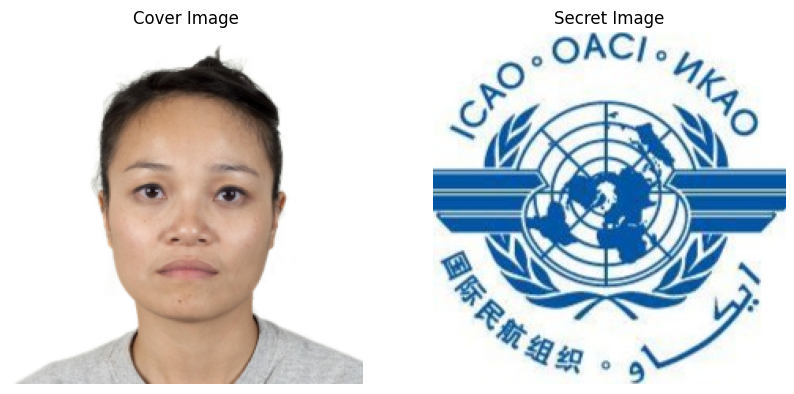

In [8]:
# Set up the figure to display both images
plt.figure(figsize=(10, 5))

# Display cover image
plt.subplot(1, 2, 1)
plt.imshow(cover)
plt.title("Cover Image")
plt.axis("off")

# Display secret image
plt.subplot(1, 2, 2)
plt.imshow(secret)
plt.title("Secret Image")
plt.axis("off")

# Show the images
plt.show()

In [9]:
cover_list = [cover_norm]
result = steguz_model.hide(cover_list, secret_norm, batch_size=8) # batch size of 8 because the model was trained with a fixed batch number

2025-03-08 22:30:53.032486: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-03-08 22:30:55.409768: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-08 22:30:55.669164: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-08 22:30:55.972642: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

1/1 [==============================] - 0s 385ms/step


In [10]:
# memory usage in GB
steguz_model.gpu_memory_usage()

Values are in GB.


{'current': 0.012933969497680664, 'peak': 2.684129476547241}

In [11]:
steguz_model.gpu_memory_reset()

GPU memory has been reset.


In [12]:
stego = result["stego_images"][0]
result

{'stego_images': [array([[[239, 239, 243],
          [242, 244, 239],
          [240, 243, 246],
          ...,
          [244, 245, 239],
          [237, 239, 245],
          [242, 244, 237]],
  
         [[242, 241, 239],
          [239, 240, 243],
          [242, 243, 238],
          ...,
          [239, 241, 246],
          [244, 244, 241],
          [239, 241, 246]],
  
         [[239, 239, 243],
          [242, 244, 239],
          [240, 243, 246],
          ...,
          [244, 245, 239],
          [237, 239, 245],
          [242, 244, 237]],
  
         ...,
  
         [[244, 242, 238],
          [241, 241, 244],
          [242, 243, 238],
          ...,
          [187, 191, 198],
          [190, 191, 190],
          [182, 185, 193]],
  
         [[240, 239, 242],
          [243, 243, 239],
          [238, 243, 246],
          ...,
          [188, 190, 184],
          [184, 186, 194],
          [181, 185, 179]],
  
         [[243, 240, 237],
          [240, 240, 244],
        

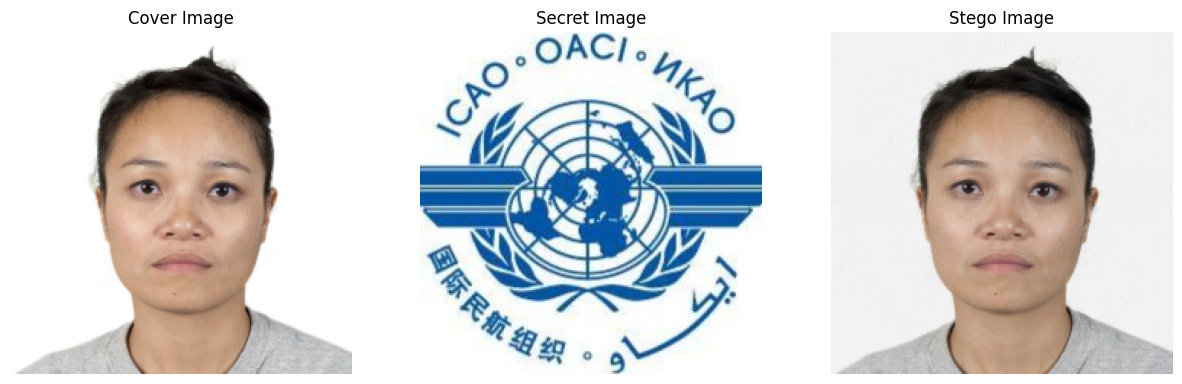

In [13]:
# Set up the figure with three subplots
plt.figure(figsize=(15, 5))

# Display the cover image
plt.subplot(1, 3, 1)
plt.imshow(cover)
plt.title("Cover Image")
plt.axis("off")

# Display the secret image
plt.subplot(1, 3, 2)
plt.imshow(secret)
plt.title("Secret Image")
plt.axis("off")

# Display the stego image
plt.subplot(1, 3, 3)
plt.imshow(stego)
plt.title("Stego Image")
plt.axis("off")

plt.show()

### Compute metrics

In [14]:
evaluator = Metrics(cover.astype(np.uint8), stego.astype(np.uint8))
evaluator.compute_all()

{'ssim': 0.9239853606175644,
 'mse': 124.07354113520408,
 'psnr': 27.19401183431397}

### Data revealing testing for one image

### Data hiding testing for many images